## 2.2 Algorithms And Techniques
For the purpose of this analysis we will use two machine learning algorithms:
* Linear Regression. Linear regression is a simple and fast algorithm. As we saw previously in our Exploratory Data Analysis (EDA) point 2.1.1, a linear regression on a single datapoint alone could give us an r2 score of more than 40%. Apart from that, linear regression is one of the algorithms integrated on Google BigQuery. This means that we can re-train a model and predict the values of records directly in our database.
* Adaboost Regressor. As we saw in our EDA, we do have a certain number of outliers. The adaboost regressor algorithm handles outlier cases slightly better as it fits additional copies of the original regressors, focusing on the difficult cases [[1]](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html "SciKit Learn's documentation").

## 2.3 Benchmark
As a benchmark, we will a granular view of the median `price_per_sq_m`, namely we will use the median `price_per_sq_m` per post code. That is, for every record in our dataset, our predicted benchmark price will be the median `price_per_sq_m` for the last 6 months.

# 3 Methodology
## 3.1 Data Preprocessing
We will take the following pre-processing steps:
* Encode the `property_type` variable as `property_type_apartment`. The encoded variable has value `1` if the `property_type` is apartment and `0` for all house types.
* Encode the `ownership_type` variable as `ownership_full`. The encoded variable is `1` only if full ownership rights are for sale (not as a part of a building cooperative).
* The post code is extracted from the `address` column. The post code is later used to join the National Health Institute (NHI) data as well as the Google Maps data.
* Add the count of lodging places and dining places from the Google Maps dataset. This is done by counting the number of places from the dataset by post code where the place type is dining or lodging.
* Add the latest percentage of university graduates per post code. This is done by selecting the latest date where the percentage of graduates is available. The statistic is already aggregated by NHI by area name so it only needs to be joined to the main dataset.
* The training pipeline also includes scaling and normalizing of all features.

## 3.2 Implementation

## 3.3 Refinement

In [41]:
import pandas as pd
import numpy as np
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import utils as u
import custom_transformers as ct

In [42]:
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
from IPython.display import display, HTML
%matplotlib inline
sns.set(style='dark')
plt.rcParams['figure.figsize'] = [14, 10]

In [43]:
sample_size = 2
random_seed = 42
test_size = 0.3
cv = 3

In [44]:
queries = u.get_queries('queries')

In [45]:
bq_client = bigquery.Client()

In [46]:
data = u.get_data(queries, 'training_data.sql', bq_client)

In [47]:
data.head()

,ad_id,apt_id,time_s,property_type_apartment,construction_year,ownership_full,floor,num_bedrooms,address,price_per_sq_m
0,154481527,None,NaN,1,2006.0,0,7.0,3.0,Rubina Ranas gat...,99772.0
1,154434920,None,NaN,1,1979.0,0,1.0,2.0,"Grefsenveien 28,...",69059.0
2,154516679,None,NaN,1,1918.0,0,2.0,2.0,"Haralds vei 6, 0...",86763.0
3,147803036,None,NaN,0,2010.0,1,NaN,4.0,"Dalsveien 56 D, ...",70699.0
4,150211925,None,NaN,1,2019.0,0,2.0,2.0,"Midtveien 47, 05...",70560.0


In [48]:
data.shape

(1440, 10)

In [49]:
data = data[data.address.notnull()].copy()

In [50]:
data_sample = data.groupby('ad_id').apply(lambda obj: obj.sample(n=sample_size, random_state=random_seed)
                                          if len(obj) > sample_size
                                          else obj.sample(len(obj)))

In [51]:
data = data.set_index(['ad_id', 'apt_id'], drop=True)

In [52]:
data.shape

(1440, 8)

In [53]:
data_enrichment = [('extract_post_code', ct.PostCodeExtractor()),
                   ('add_area_name', ct.PostCodeEnricher()),
                   ('add_gmaps_data', ct.GmapsPlaceEnricher()),
                   ('add_nhs_data', ct.NhsDataEnricher()),
                   ('add_historic_data', ct.HistoricDataEnricher()),
                   ('remove_helper_columns', ct.AuxiliaryColumnRemover()),
                   ('impute_features', ct.CustomImputer())]

model_steps = [('scale', preprocessing.MinMaxScaler()),
               ('normalize', preprocessing.Normalizer()),
               ('model', 'passthrough')]

models = [ensemble.AdaBoostRegressor(random_state=random_seed),
          linear_model.LinearRegression()]

model_params = {'model': models}

In [54]:
enrichment_pipeline = pipeline.Pipeline(data_enrichment)

In [55]:
model_pipeline = pipeline.Pipeline(model_steps)

In [56]:
data.isna().sum(axis=0).sort_values(ascending=False)[:20]

floor                      232
time_s                      91
num_bedrooms                63
price_per_sq_m               0
address                      0
ownership_full               0
construction_year            0
property_type_apartment      0
dtype: int64

In [57]:
X = data.drop('price_per_sq_m', axis=1)
y = data.price_per_sq_m

In [58]:
X = enrichment_pipeline.fit_transform(X)

In [59]:
y_bench = X.median_price_per_sq_m
X = X.drop('median_price_per_sq_m', axis=1)

In [60]:
X.head()

,,time_s,property_type_apartment,construction_year,ownership_full,floor,num_bedrooms,num_lodging_places,num_dining_places,uni_graduates
ad_id,apt_id,,,,,,,,,
154481527,NaN,14400.0,1,2006.0,0,7.0,3.0,6.0,3.0,0.64
154434920,NaN,14400.0,1,1979.0,0,1.0,2.0,1.0,1.0,0.76
154516679,NaN,14400.0,1,1918.0,0,2.0,2.0,0.0,0.0,0.68
147803036,NaN,14400.0,0,2010.0,1,1.0,4.0,0.0,0.0,0.77
150211925,NaN,14400.0,1,2019.0,0,2.0,2.0,1.0,0.0,0.55


In [61]:
X_train, X_test, y_train, y_test, y_bench_train, y_bench_test = model_selection.train_test_split(X, y, y_bench, test_size=test_size, random_state=random_seed)

In [62]:
X_train.shape

(1008, 9)

In [63]:
grid = model_selection.GridSearchCV(model_pipeline, cv=cv, n_jobs=1, param_grid=model_params, scoring='neg_mean_absolute_error')

In [64]:
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('normalize',
                                        Normalizer(copy=True, norm='l2')),
                                       ('model', 'passthrough')],
                                verbose=False),
             iid='warn', n_jobs=1,
             param_grid={'model': [AdaBoostRegressor(base_estimator=None,
                                                     learning_rate=1.0,
                                                     loss='linear',
                                                     n_estimators=50,
                                                     random_state=42),
                                   LinearRegression(copy_X=True,
                

In [65]:
grid.best_score_

-11377.210660947703

In [66]:
final_model = grid.best_estimator_

In [67]:
final_model

Pipeline(memory=None,
         steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('normalize', Normalizer(copy=True, norm='l2')),
                ('model',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

# Results

In [68]:
learning_curve_res = u.get_learning_curves(final_model, X_train, y_train, score='neg_mean_absolute_error', cv=cv)

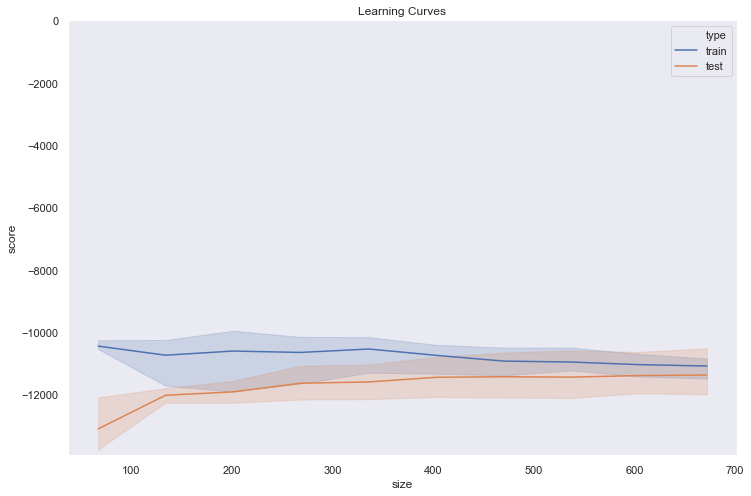

In [69]:
fig = plt.figure(figsize = (12, 8))
plt.title('Learning Curves')
sns.lineplot(x='size', y='score', hue='type', data=learning_curve_res)
plt.ylim([plt.ylim()[0], 0])
plt.show()

In [70]:
cv_res = u.get_cv_res(final_model,
                      X_train,
                      y_train,
                      score=['neg_mean_absolute_error',
                             'r2',
                             'explained_variance',
                             'max_error'],
                      cv=cv)

In [71]:
print_cv_res(cv_res)

Mean fit_time, 0.00
Mean score_time, 0.00
Mean test_neg_mean_absolute_error, -11377.21
Mean test_r2, 0.46
Mean test_explained_variance, 0.47
Mean test_max_error, -66381.90


In [72]:
pred = final_model.predict(X_test)

In [73]:
y_pred = pd.Series(pred, index=y_test.index, name='predicted')

In [74]:
u.print_scores(y_test, y_pred)

mean_absolute_error: 11753.79
explained_variance: 0.50
r2: 0.50
max_error: 89077.91


In [75]:
u.print_scores(y_test, y_bench_test)

mean_absolute_error: 9221.22
explained_variance: 0.57
r2: 0.57
max_error: 89991.00


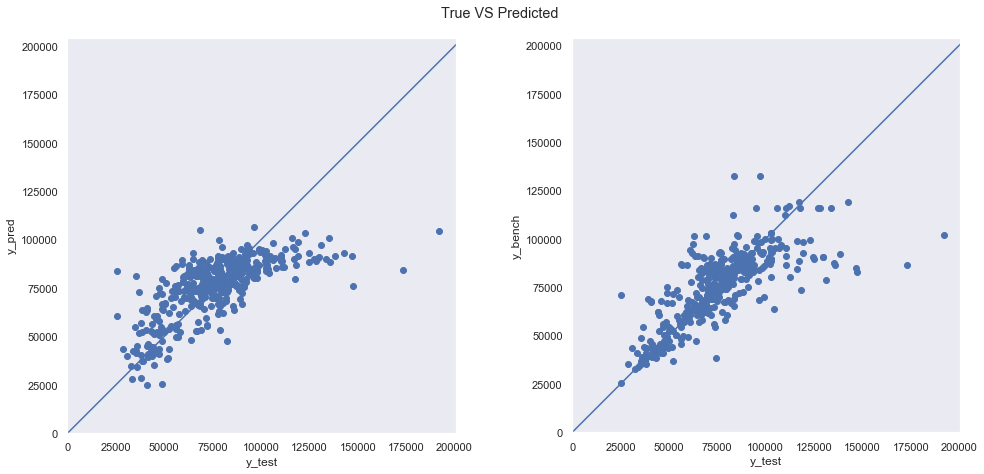

In [76]:
fig = plt.figure(figsize=(16, 8))
i = 1
for dataset, dataset_name in zip([y_pred, y_bench_test], ['y_pred', 'y_bench']):
    ax = plt.subplot(1, 2, i)
    plt.scatter(y_test, dataset)
    ax.set_xlabel('y_test')
    ax.set_ylabel(dataset_name)
    ax.axis('equal')
    ax.axis('square')
    ax.set_xlim([0,plt.xlim()[1]])
    ax.set_ylim([0,plt.ylim()[1]])
    _ = plt.plot([-5e7, 5e7], [-5e7, 5e7])
    i += 1
plt.suptitle('True VS Predicted', y=0.9)
plt.subplots_adjust(wspace=0.3)
plt.show()

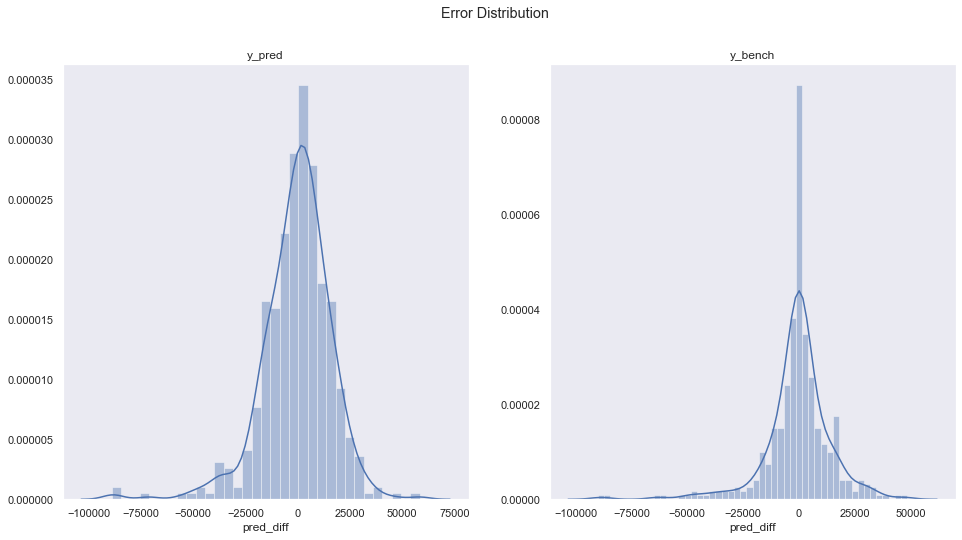

In [77]:
fig = plt.figure(figsize=(16, 8))
i = 1
for dataset, dataset_name in zip([y_pred, y_bench_test], ['y_pred', 'y_bench']):
    ax = plt.subplot(1, 2, i)
    to_plot = dataset.rename('predicted').to_frame().join(y_test)
    to_plot['pred_diff'] = to_plot['predicted'] - to_plot['price_per_sq_m']
    sns.distplot(to_plot.pred_diff)
    plt.title(dataset_name)
    i += 1
plt.suptitle('Error Distribution')
plt.show()

In [78]:
if isinstance(final_model.named_steps['model'], linear_model.LinearRegression):
    feature_importances = pd.Series(final_model.named_steps['model'].coef_, index=X.columns)
    xlabel = 'feature coefficient'
elif isinstance(final_model.named_steps['model'], ensemble.AdaBoostRegressor):
    feature_importances = pd.Series(final_model.named_steps['model'].feature_importances_, index=X.columns)
    xlabel = 'feature importance'

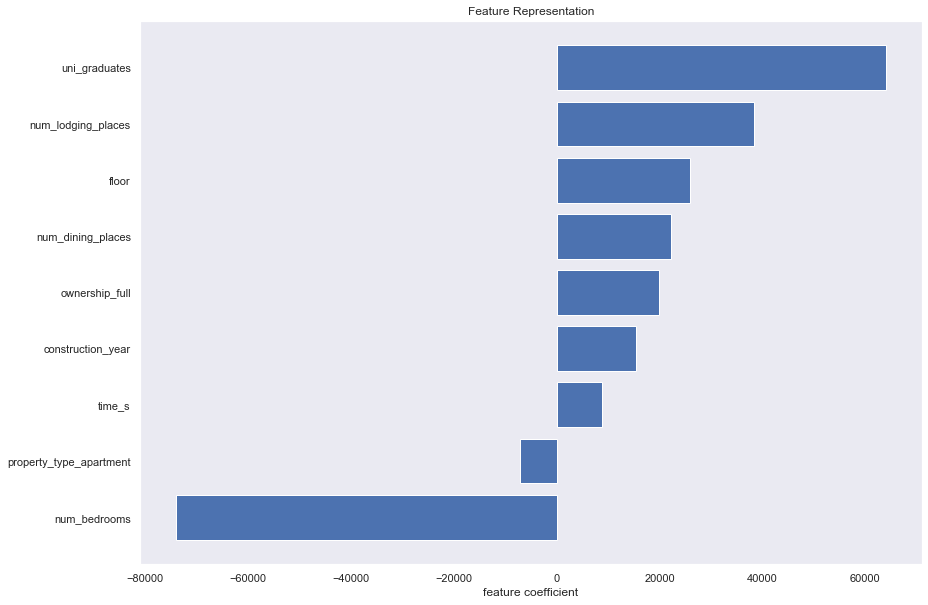

In [79]:
to_plot = feature_importances.sort_values()
plt.yticks(range(len(to_plot)), to_plot.index)
plt.title('Feature Representation')
plt.barh(range(len(to_plot)), to_plot)
plt.xlabel(xlabel)
plt.show()